In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_visualize
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg
import os

In [ ]:
plt.style.use('../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [ ]:
halo_smooth = np.linspace(11, 14, 100)

In [ ]:
test = []

for file in os.listdir("../data/"):

    if file.endswith("h5"):

        ii = jsm_ancillary.load_sample("../data/"+file)

        print("loaded", file)

        test.append([np.log10(ii.host_mass.values), np.log10(1/(1+ii.host_z50.values)), np.log10(ii.N_pres1.values)])

loaded 11.2_files.h5
loaded 11.8_files.h5
loaded 13.4_files.h5
loaded 12.6_files.h5
loaded 13.2_files.h5
loaded 12.0_files.h5
loaded 13.8_files.h5
loaded 11.4_files.h5
loaded 12.4_files.h5
loaded 14.0_files.h5
loaded 13.6_files.h5
loaded 11.0_files.h5
loaded 11.6_files.h5
loaded 12.2_files.h5
loaded 13.0_files.h5
loaded 12.8_files.h5


In [ ]:
def consolidate(test_index):

    host_mass = test_index[0][0] 
    z50_quant = np.percentile(test_index[1], np.array([16, 50, 84]))
    Nsub_quant = np.percentile(test_index[2], np.array([16, 50, 84]))

    return host_mass, z50_quant, Nsub_quant

In [ ]:
from scipy.optimize import minimize

def fit_line_asym_errors(x, y, yerr_up, yerr_down, p0=(1.0, 0.0)):
    """
    Fit y = m x + b with asymmetric y-errors using weighted least squares.

    Parameters
    ----------
    x : array_like
        Independent variable
    y : array_like
        Dependent variable
    yerr_up : array_like
        Upper (positive) y-uncertainties
    yerr_down : array_like
        Lower (negative) y-uncertainties
    p0 : tuple, optional
        Initial guess for (m, b)

    Returns
    -------
    m, b : float
        Best-fit slope and intercept
    result : OptimizeResult
        Full scipy optimization result
    """

    x = np.asarray(x)
    y = np.asarray(y)
    yerr_up = np.asarray(yerr_up)
    yerr_down = np.asarray(yerr_down)

    def chi2(params):
        m, b = params
        y_model = m * x + b

        # Choose uncertainty based on which side of the point the model is on
        sigma = np.where(y_model > y, yerr_up, yerr_down)

        return np.sum(((y - y_model) / sigma) ** 2)

    result = minimize(chi2, p0, method="Nelder-Mead")

    m_best, b_best = result.x
    return m_best, b_best, result


In [ ]:
x_data = []
y_data = []
y_err_up = []
y_err_down = []

for i in test:
    host_mass, z50_quant, Nsub_quant = consolidate(i)
    x_data.append(host_mass)
    y_data.append(z50_quant[1])
    y_err_up.append(z50_quant[2])
    y_err_down.append(z50_quant[0])

m_z50, b_z50, res_z50 = fit_line_asym_errors(x_data, y_data, y_err_up, y_err_down, p0=(0.5, 1.0))

In [ ]:
x_data = []
y_data = []
y_err_up = []
y_err_down = []

for i in test:
    host_mass, z50_quant, Nsub_quant = consolidate(i)
    x_data.append(host_mass)
    y_data.append(Nsub_quant[1])
    y_err_up.append(Nsub_quant[2])
    y_err_down.append(Nsub_quant[0])

m_Nsub, b_Nsub, res_Nsub = fit_line_asym_errors(x_data, y_data, y_err_up, y_err_down, p0=(1, 1.0))


In [ ]:
def z50_line(log_Mvir):
    return m_z50*log_Mvir+b_z50

def Nsub_line(log_Mvir):
    return m_Nsub*log_Mvir+b_Nsub

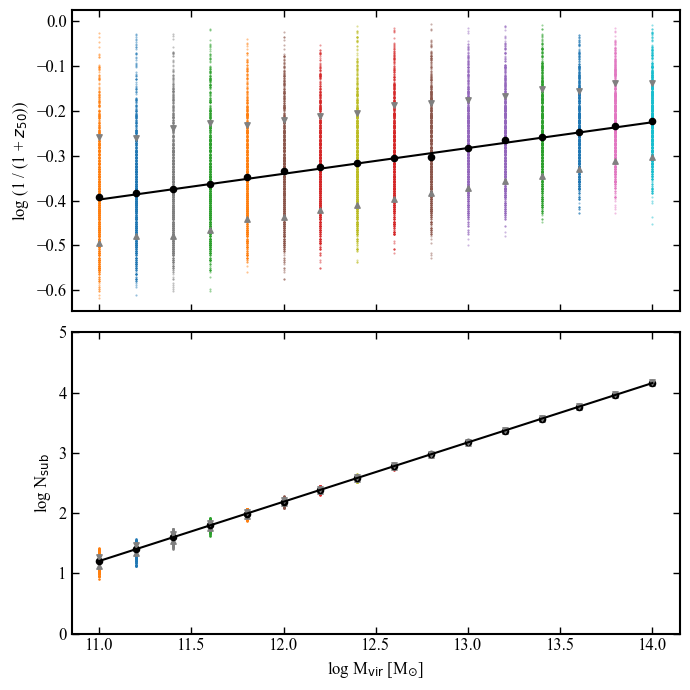

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(double_textwidth, double_textwidth), sharex=True)

for i in test:
    host_mass, z50_quant, Nsub_quant = consolidate(i)

    ax[0].scatter(i[0], i[1], marker=".", s=1, alpha=0.5)
    ax[0].scatter(host_mass, z50_quant[0], color="grey", marker="^", s=15)
    ax[0].scatter(host_mass, z50_quant[1], color="k", s=20)
    ax[0].scatter(host_mass, z50_quant[2], color="grey", marker="v", s=15)

    ax[1].scatter(i[0], i[2], marker=".", s=3)
    ax[1].scatter(host_mass, Nsub_quant[0], color="grey", marker="^", s=15)
    ax[1].scatter(host_mass, Nsub_quant[1], color="k", s=20)
    ax[1].scatter(host_mass, Nsub_quant[2], color="grey", marker="v", s=15)

ax[0].plot(halo_smooth, z50_line(halo_smooth), color="k")
ax[1].plot(halo_smooth, Nsub_line(halo_smooth), color="k")

ax[1].set_xlabel("log M$_{\\rm vir}$ [M$_{\\odot}$]")
ax[0].set_ylabel("log (1 / (1 + $z_{50}$))")
ax[1].set_ylabel("log N$_{\\rm sub}$")
ax[1].set_ylim(0,5)

plt.tight_layout()
plt.show()

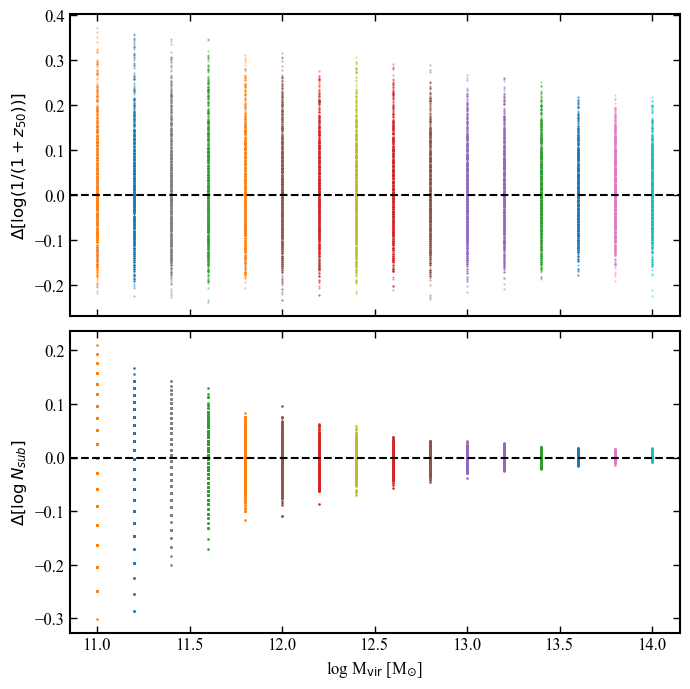

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(double_textwidth, double_textwidth), sharex=True)

for i in test:
    host_mass, z50_quant, Nsub_quant = consolidate(i)

    ax[0].scatter(i[0], i[1] - z50_line(i[0]), marker=".", s=1, alpha=0.5)

    ax[1].scatter(i[0], i[2] - Nsub_line(i[0]), marker=".", s=3)

ax[1].set_xlabel("log M$_{\\rm vir}$ [M$_{\\odot}$]")
ax[0].set_ylabel("$\\Delta [\\log (1/(1+z_{50}))] $")
ax[1].set_ylabel("$\\Delta \\left[\\log N_{sub} \\right]$")

ax[0].axhline(0, ls="--", color="k", zorder=11)
ax[1].axhline(0, ls="--", color="k", zorder=11)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib as mpl

vmin, vmax = 11.0, 14.0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.viridis


zorder_min = 1
zorder_max = 10

def quadrant_percentages_plot(x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    valid = (x != 0) & (y != 0)
    x, y = x[valid], y[valid]
    total = len(x)

    q1 = np.sum((x > 0) & (y > 0)) / total * 100
    q2 = np.sum((x < 0) & (y > 0)) / total * 100
    q3 = np.sum((x < 0) & (y < 0)) / total * 100
    q4 = np.sum((x > 0) & (y < 0)) / total * 100

    txt = [f"{q1:.1f}%", f"{q4:.1f}%", f"{q3:.1f}%", f"{q2:.1f}%"]

    rho = jsm_stats.correlation(x, y)

    return txt, f"{rho:.3f}"

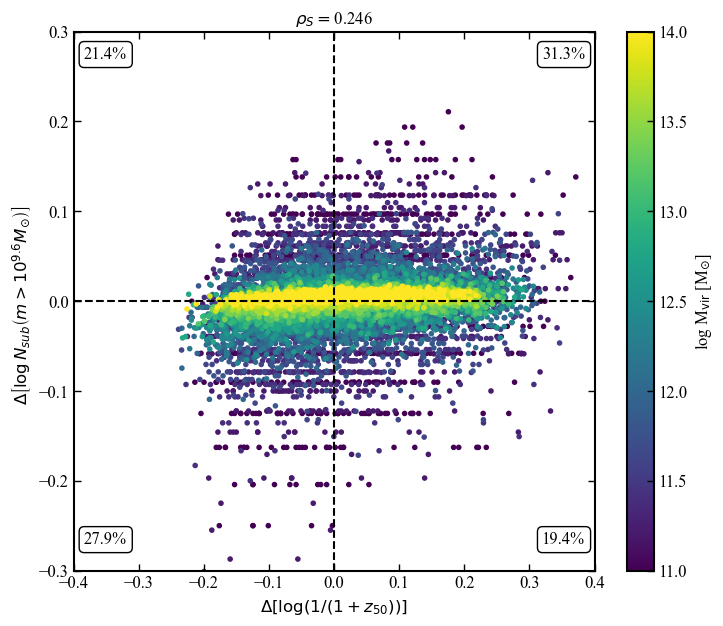

In [ ]:
fig, ax = plt.subplots(figsize=(double_textwidth*1.2, double_textwidth))

xvals = []
yvals = []

for i in test:
    delta_z50_i =  i[1] - z50_line(i[0])
    delta_Nsub_i = i[2] - Nsub_line(i[0])

    xvals.extend(delta_z50_i)
    yvals.extend(delta_Nsub_i)
    
    color = cmap(norm(i[0]))  # map scalar → color
    zorder = zorder_min + (zorder_max - zorder_min) * norm(i[0][0])

    ax.scatter(delta_z50_i, delta_Nsub_i, marker=".", color=color, zorder=zorder)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for older matplotlib versions

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("log M$_{\\rm vir}$ [M$_{\\odot}$]")

ax.set_xlabel("$\\Delta [\\log (1/(1+z_{50}))] $")
ax.set_ylabel("$\\Delta \\left[\\log N_{sub} \\left(m > 10^{9.6} M_{\\odot} \\right) \\right]$  ")

ax.axhline(0, ls="--", color="k", zorder=11)
ax.axvline(0, ls="--", color="k", zorder=11)

ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-0.4, 0.4)

qs, rho = quadrant_percentages_plot(xvals, yvals)

ax.set_title("$\\rho_S =$"+rho)
ax.text(0.9, 0.95, qs[0], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))
ax.text(0.9, 0.05, qs[1], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))
ax.text(0.02, 0.05, qs[2], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))
ax.text(0.02, 0.95, qs[3], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))


plt.show()